In [1]:
from torchLearning import *

In [2]:
torch.manual_seed(1998)

# 加载原始的数据集
X, y = tensorGenReg(w=[2,-1,3,1,2], bias=False, degree=2)

# 如果深度神经网络模型需要学习的数据集的特征变量和标签是分开存储的, 则先将特征变量和标签按照样本的编号进行合并(Dataset, TorchDataset或者自定义集成Dataset的类)
# 对于合并后的完整的数据集, 先根据指定的比例将其划分为训练数据集和测试数据集(torch.utils.data.random_split)
# 再根据指定的样本容量将训练数据集和测试数据集分别划分为若干个互不相交的子数据集(DataLoader)
dataset_train, dataset_test = split_loader(X=X, y=y)

In [3]:
# 搭建模型: 使用面向对象(定义类/创建对象)的方式 继承nn.Module类
class net_class2(nn.Module):
    # 构造器 + 类/对象属性
    # => 子类的对象调用父类的构造器
    # => 神经网络模型中的各种层
    def __init__(self, in_features=2, hidden_features=[4, 4], out_features=1, bias=True, act_fun=torch.relu, BN_mode=None, momentum=0.1):
        super(net_class2, self).__init__()

        self.hidden1_linear = nn.Linear(in_features=in_features, out_features=hidden_features[0], bias=bias)
        self.hidden1_bn1d = nn.BatchNorm1d(num_features=hidden_features[0], momentum=momentum)
        
        self.hidden2_linear = nn.Linear(in_features=hidden_features[0], out_features=hidden_features[1], bias=bias)
        self.hidden2_bn1d = nn.BatchNorm1d(num_features=hidden_features[1], momentum=momentum)
        
        self.output_linear = nn.Linear(in_features=hidden_features[1], out_features=out_features, bias=bias)
        self.BN_mode = BN_mode
        self.act_fun = act_fun
        
    # 方法
    # => 前向传播: 数据从神经网络的输入层 -> 隐藏层 -> 输出层; 逐层完成整合信息+加工信息
    def forward(self, X):
        if self.BN_mode == None:
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 加工信息
            sigma = self.act_fun(zhat)

            # 隐藏层第一层 -> 隐藏层第二层(数据归一化层不工作) -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden2_linear(sigma)
            # 加工信息
            sigma = self.act_fun(zhat)

            # 隐藏层第三层 -> 隐藏层第四层(数据归一化层不工作) -> 输出层
            # 整合信息
            zhat = self.output_linear(sigma)
            
        elif self.BN_mode == 'before':
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 调整当前数据的各个原始特征变量or中间隐藏变量的数据的分布
            zhat_norm = self.hidden1_bn1d(zhat)       
            # 加工信息
            sigma = self.act_fun(zhat_norm)

            # 隐藏层第一层 -> 隐藏层第二层(数据归一化层) -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden2_linear(sigma)
            # 调整当前数据的各个原始特征变量or中间隐藏变量的数据的分布
            zhat_norm = self.hidden2_bn1d(zhat)
            # 加工信息
            sigma = self.act_fun(zhat_norm)

            # 隐藏层等三层 -> 输出层
            zhat = self.output_linear(sigma)
        
        elif self.BN_mode == 'after':
            # 输入层 -> 隐藏层第一层
            # 整合信息
            zhat = self.hidden1_linear(X)
            # 加工信息
            sigma = self.act_fun(zhat)
            # 调整当前数据的各个原始特征变量or中间隐藏变量的数据的分布
            sigma_norm = self.hidden1_bn1d(sigma)

            # 隐藏层第一层 -> 隐藏层第二层(数据归一化层) -> 隐藏层第三层
            # 整合信息
            zhat = self.hidden2_linear(sigma_norm)
            # 加工信息
            sigma = self.act_fun(zhat)
            # 调整分布
            sigma_norm = self.hidden2_bn1d(sigma)

            # 隐藏层第三层 -> 输出层
            # 整合信息
            zhat = self.output_linear(sigma_norm)
        return zhat

In [8]:
torch.manual_seed(55)

# 设置对完整的训练数据集学习的遍数
n_epochs = 20
# 实例化模型(模型中的全部参数将根据随机数种子进行随机初始化)
tanh_model_1 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")
# tanh_model_2 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")
# tanh_model_3 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")
# tanh_model_4 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [5]:
# 第一个模型进行训练
losses_train1, losses_test1 = calc_train_test_losses(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                                                    model=tanh_model_1, criterion=nn.MSELoss(), optimizer=optim.SGD(params=tanh_model_1.parameters(), lr=0.03), task="reg", evaluation=calc_mse)

In [6]:
torch.manual_seed(55)
tanh_model_2 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [7]:
# 第二个模型进行训练
losses_train2, losses_test2 = calc_train_test_losses(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                                                    model=tanh_model_2, criterion=nn.MSELoss(), optimizer=optim.SGD(params=tanh_model_2.parameters(), lr=0.01), task="reg", evaluation=calc_mse)

In [8]:
torch.manual_seed(55)
tanh_model_3 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [9]:
# 第三个模型进行训练
losses_train3, losses_test3 = calc_train_test_losses(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                                                    model=tanh_model_3, criterion=nn.MSELoss(), optimizer=optim.SGD(params=tanh_model_3.parameters(), lr=0.005), task="reg", evaluation=calc_mse)

In [11]:
tanh_model_4 = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [12]:
# 第四个模型进行训练
losses_train4, losses_test4 = calc_train_test_losses(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                                                    model=tanh_model_4, criterion=nn.MSELoss(), optimizer=optim.SGD(params=tanh_model_4.parameters(), lr=0.001), task="reg", evaluation=calc_mse)

##### 在一张图上比对参与实验的模型的性能评估指标值随着某个超参数变化的曲线

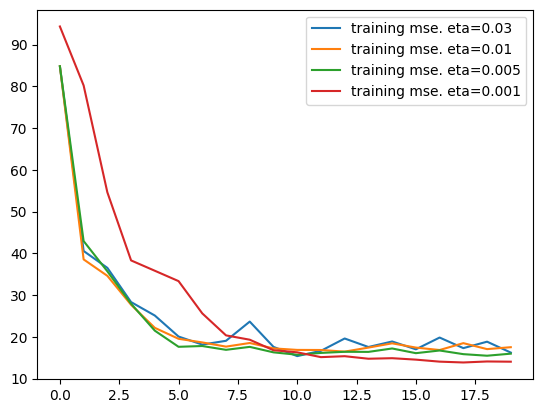

In [13]:
import numpy
plt.plot(list(range(n_epochs)), losses_train1, label="training mse. eta=0.03")
plt.plot(list(range(n_epochs)), losses_train2, label="training mse. eta=0.01")
plt.plot(list(range(n_epochs)), losses_train3, label="training mse. eta=0.005")
plt.plot(list(range(n_epochs)), losses_train4, label="training mse. eta=0.001")
plt.legend(loc="upper right")
plt.show()

In [4]:
torch.manual_seed(1998)

# 实例化模型, 随机初始化模型的参数
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [5]:
fit_record_evaluation(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=3,
                     model=tanh_model, criterion=nn.MSELoss(), optimizer=optim.SGD(tanh_model.parameters(), lr=0.03),
                     task="reg", evaluation=calc_mse)

([tensor(38.9092, grad_fn=<MseLossBackward0>),
  tensor(32.5596, grad_fn=<MseLossBackward0>),
  tensor(27.5552, grad_fn=<MseLossBackward0>)],
 [tensor(36.6877, grad_fn=<MseLossBackward0>),
  tensor(32.5292, grad_fn=<MseLossBackward0>),
  tensor(27.5888, grad_fn=<MseLossBackward0>)])

In [14]:
dataset_train

In [4]:
# 使用input()函数接收User的键盘输入
a = input()

 1


In [5]:
type(a)

str

In [6]:
a = float(input())

 1


In [7]:
type(a)

float

In [8]:
a

1.0

In [4]:
torch.manual_seed(1998)

# 实例化模型, 随机初始化模型的参数
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

In [7]:
input("Do you want to continue the iteration? [y/n]")

Do you want to continue the iteration? [y/n] y


'y'

In [8]:
lst1 = [1, 2, 3]
lst2 = [2, 3, 4]

In [9]:
# extend()方法, 将lst2中的每一个基本元素(能够用一个索引获取的元素)追加到lst1中
lst1.extend(lst2)

In [10]:
lst1

[1, 2, 3, 2, 3, 4]

In [11]:
# append()方法, 将整个lst2当作一个基本元素追加到lst1中
lst1.append(lst2)

In [12]:
lst1

[1, 2, 3, 2, 3, 4, [2, 3, 4]]

In [13]:
lst3 = [1, 2, [1, 2, 3]]
lst1.extend(lst3)

In [14]:
lst1

[1, 2, 3, 2, 3, 4, [2, 3, 4], 1, 2, [1, 2, 3]]

In [10]:
# 在计算机的内存中逐个存储多个数值 => 选择列表数据结构
losses_train = []
losses_test = []

while input("Do you want to continue the iteration? [y/n]") == 'y':
    n_epochs = int(input("please input the number of epochs: "))
    lr = float(input("please input the learning rate: "))
    i_iter_losses_train, i_iter_losses_test = fit_record_evaluation(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                     model=tanh_model, criterion=nn.MSELoss(), optimizer=optim.SGD(tanh_model.parameters(), lr=lr),
                     task="reg", evaluation=calc_mse)

    losses_train.extend(i_iter_losses_train)
    losses_test.extend(i_iter_losses_test)

Do you want to continue the iteration? [y/n] y
please input the number of epochs:  20
please input the learning rate:  0.03
Do you want to continue the iteration? [y/n] y
please input the number of epochs:  20
please input the learning rate:  0.01
Do you want to continue the iteration? [y/n] y
please input the number of epochs:  20
please input the learning rate:  0.005
Do you want to continue the iteration? [y/n] n


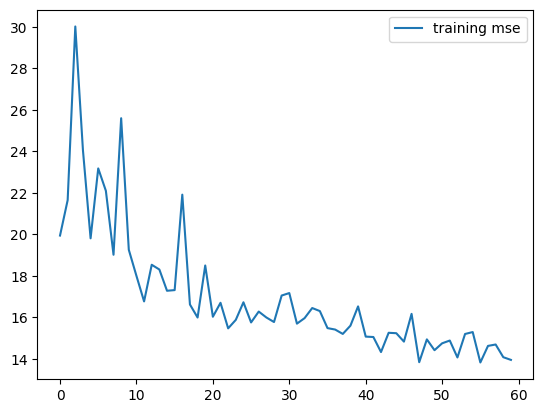

In [11]:
plt.plot(losses_train, label="training mse")
plt.legend(loc="upper right")
plt.show()

In [12]:
len(losses_train)

60

In [13]:
# 在计算机的内存中逐个存储多个数值 => 选择列表数据结构
losses_train2 = []
losses_test2 = []

while input("Do you want to continue the iteration? [y/n]") == 'y':
    n_epochs = int(input("please input the number of epochs: "))
    lr = float(input("please input the learning rate: "))
    i_iter_losses_train, i_iter_losses_test = fit_record_evaluation(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                     model=tanh_model, criterion=nn.MSELoss(), optimizer=optim.SGD(tanh_model.parameters(), lr=lr),
                     task="reg", evaluation=calc_mse)

    losses_train2.extend(i_iter_losses_train)
    losses_test2.extend(i_iter_losses_test)

Do you want to continue the iteration? [y/n] y
please input the number of epochs:  60
please input the learning rate:  0.03
Do you want to continue the iteration? [y/n] n


##### 比较动态学习率训练流程和静态学习率训练流程训练过程的模型性能评估指标

In [14]:
len(losses_train)
len(losses_train2)

60

60

Text(0.5, 0, '#epochs')

Text(0, 0.5, 'MSE')

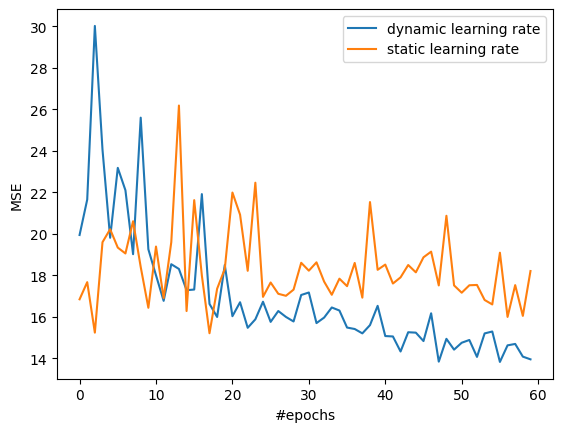

In [18]:
plt.plot(list(range(len(losses_train))), losses_train, label="dynamic learning rate")
plt.plot(list(range(len(losses_train2))), losses_train2, label="static learning rate")
plt.xlabel("#epochs")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.show()

In [19]:
# 在计算机的内存中逐个存储多个数值 => 选择列表数据结构
losses_train3 = []
losses_test3 = []

while input("Do you want to continue the iteration? [y/n]") == 'y':
    n_epochs = int(input("please input the number of epochs: "))
    lr = float(input("please input the learning rate: "))
    i_iter_losses_train, i_iter_losses_test = fit_record_evaluation(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                     model=tanh_model, criterion=nn.MSELoss(), optimizer=optim.SGD(tanh_model.parameters(), lr=lr),
                     task="reg", evaluation=calc_mse)

    losses_train3.extend(i_iter_losses_train)
    losses_test3.extend(i_iter_losses_test)

Do you want to continue the iteration? [y/n] y
please input the number of epochs:  60
please input the learning rate:  0.01
Do you want to continue the iteration? [y/n] n


Text(0.5, 0, '#epochs')

Text(0, 0.5, 'MSE')

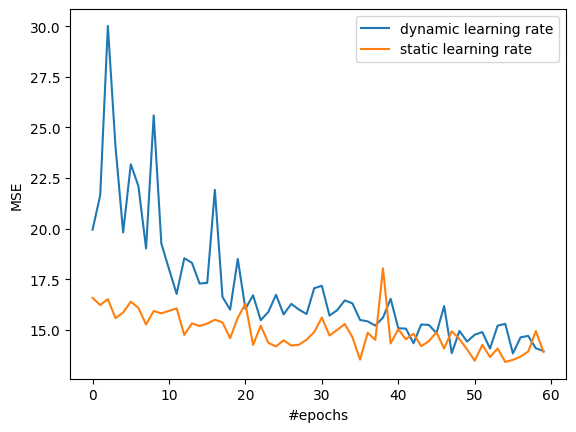

In [20]:
plt.plot(list(range(len(losses_train))), losses_train, label="dynamic learning rate")
plt.plot(list(range(len(losses_train3))), losses_train3, label="static learning rate")
plt.xlabel("#epochs")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.show()

In [21]:
l1 = list(range(10))
l1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [22]:
l1[3:5]

[3, 4]

In [23]:
l2 = list(range(1, 3))
l2

[1, 2]

In [24]:
for i, j in zip(l2, l1[3:5]):
    print(i, j)

1 3
2 4


##### 使用tensorboardX模块中的类SummaryWriter

In [25]:
from tensorboardX import SummaryWriter

In [26]:
writer = SummaryWriter(logdir="reg_loss3")

In [27]:
# 在计算机的内存中存储一个数, 这个数代表后续的数值累加的结果
epochs_cnt = 0
# 在计算机的内存中逐个存储多个数 => 选择列表数据结构
losses_train = []
losses_test = []

# 实例化模型
torch.manual_seed(1998)

# 实例化模型, 随机初始化模型的参数
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_mode="before")

while input("Do you want to continue the iteration? [y/n]") == 'y':
    n_epochs = int(input("please input the number of epochs: "))
    lr = float(input("please input the learning rate: "))
    i_iter_losses_train, i_iter_losses_test = fit_record_evaluation(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                     model=tanh_model, criterion=nn.MSELoss(), optimizer=optim.SGD(tanh_model.parameters(), lr=lr),
                     task="reg", evaluation=calc_mse)

    losses_train.extend(i_iter_losses_train)
    losses_test.extend(i_iter_losses_test)

    for curr_epochs, curr_losses_train in zip(list(range(epochs_cnt, epochs_cnt+n_epochs)), losses_train[epochs_cnt:epochs_cnt+n_epochs]):
        writer.add_scalar("training mse", curr_losses_train, curr_epochs)
    for curr_epochs, curr_losses_test in zip(list(range(epochs_cnt, epochs_cnt+n_epochs)), losses_test[epochs_cnt:epochs_cnt+n_epochs]):
        writer.add_scalar("training mse", curr_losses_test, curr_epochs)

    epochs_cnt = epochs_cnt + n_epochs

Do you want to continue the iteration? [y/n] y
please input the number of epochs:  30
please input the learning rate:  0.03
Do you want to continue the iteration? [y/n] y
please input the number of epochs:  30
please input the learning rate:  0.01
Do you want to continue the iteration? [y/n] y
please input the number of epochs:  30
please input the learning rate:  0.005
Do you want to continue the iteration? [y/n] y
please input the number of epochs:  0.001


ValueError: invalid literal for int() with base 10: '0.001'

In [28]:
epochs_cnt

90

In [29]:
while input("Do you want to continue the iteration? [y/n]") == 'y':
    n_epochs = int(input("please input the number of epochs: "))
    lr = float(input("please input the learning rate: "))
    i_iter_losses_train, i_iter_losses_test = fit_record_evaluation(dataset_train=dataset_train, dataset_test=dataset_test, n_epochs=n_epochs,
                     model=tanh_model, criterion=nn.MSELoss(), optimizer=optim.SGD(tanh_model.parameters(), lr=lr),
                     task="reg", evaluation=calc_mse)

    losses_train.extend(i_iter_losses_train)
    losses_test.extend(i_iter_losses_test)

    for curr_epochs, curr_losses_train in zip(list(range(epochs_cnt, epochs_cnt+n_epochs)), losses_train[epochs_cnt:epochs_cnt+n_epochs]):
        writer.add_scalar("training mse", curr_losses_train, curr_epochs)
    for curr_epochs, curr_losses_test in zip(list(range(epochs_cnt, epochs_cnt+n_epochs)), losses_test[epochs_cnt:epochs_cnt+n_epochs]):
        writer.add_scalar("training mse", curr_losses_test, curr_epochs)

    epochs_cnt = epochs_cnt + n_epochs

Do you want to continue the iteration? [y/n] y
please input the number of epochs:  30
please input the learning rate:  0.05
Do you want to continue the iteration? [y/n] n
